# GCN

In [17]:
import time
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torch.optim as optim
from gcn.models import GCN
from gcn.utils import load_data, accuracy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [18]:
use_cuda = torch.cuda.is_available()
np.random.seed(42)
torch.manual_seed(42)

if use_cuda:
    torch.cuda.manual_seed(42)



In [19]:
# Load data
adj, features, labels, idx_train, idx_val, idx_test, idx, idx_map = load_data(split=[0.8, 0.1, 0.1], path="./cora/")
# split dataset into train, validation and test for 8:1:1

if use_cuda:
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()
    


Loading cora dataset...


In [20]:
def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_train.item(), loss_val.item(), acc_train.item(), acc_val.item()

In [21]:
def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    return acc_test.item()

In [22]:
# Hyper parameters
lr = 1e-3  # Initial learning rate.
weight_decay = 5e-4  # Weight decay (L2 loss on parameters).
hidden = 16  # Number of hidden units.
dropout = 0.5 # Dropout rate (1 - keep probability).
epochs = 2500  # Number of epochs to train.
fastmode = False # Validate during training pass.

In [23]:
# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=hidden,
            nclass=labels.max().item() + 1,
            dropout=dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)

if use_cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

In [24]:
# Train model
t_total = time.time()
acc_trains, acc_vals, loss_trains, loss_vals = [], [], [], []
for epoch in range(epochs):
    loss_train, loss_val, acc_train, acc_val = train(epoch)
    acc_trains.append(acc_train)
    acc_vals.append(acc_val)
    loss_trains.append(loss_train)
    loss_vals.append(loss_val)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
acc_test = test()

Epoch: 0001 loss_train: 1.9224 acc_train: 0.2424 loss_val: 1.9336 acc_val: 0.2694 time: 0.0092s
Epoch: 0002 loss_train: 1.9227 acc_train: 0.2622 loss_val: 1.9323 acc_val: 0.2768 time: 0.0069s
Epoch: 0003 loss_train: 1.9205 acc_train: 0.2682 loss_val: 1.9310 acc_val: 0.2804 time: 0.0073s
Epoch: 0004 loss_train: 1.9211 acc_train: 0.2692 loss_val: 1.9298 acc_val: 0.2768 time: 0.0071s
Epoch: 0005 loss_train: 1.9184 acc_train: 0.2886 loss_val: 1.9285 acc_val: 0.2841 time: 0.0073s
Epoch: 0006 loss_train: 1.9176 acc_train: 0.2881 loss_val: 1.9273 acc_val: 0.2878 time: 0.0073s
Epoch: 0007 loss_train: 1.9195 acc_train: 0.2881 loss_val: 1.9261 acc_val: 0.2878 time: 0.0076s
Epoch: 0008 loss_train: 1.9162 acc_train: 0.2927 loss_val: 1.9249 acc_val: 0.2878 time: 0.0071s
Epoch: 0009 loss_train: 1.9150 acc_train: 0.2959 loss_val: 1.9238 acc_val: 0.2878 time: 0.0071s
Epoch: 0010 loss_train: 1.9141 acc_train: 0.2987 loss_val: 1.9226 acc_val: 0.2952 time: 0.0070s
Epoch: 0011 loss_train: 1.9109 acc_train

Epoch: 0090 loss_train: 1.8520 acc_train: 0.3019 loss_val: 1.8413 acc_val: 0.2952 time: 0.0086s
Epoch: 0091 loss_train: 1.8414 acc_train: 0.3019 loss_val: 1.8403 acc_val: 0.2952 time: 0.0082s
Epoch: 0092 loss_train: 1.8427 acc_train: 0.3019 loss_val: 1.8393 acc_val: 0.2952 time: 0.0083s
Epoch: 0093 loss_train: 1.8444 acc_train: 0.3019 loss_val: 1.8383 acc_val: 0.2952 time: 0.0083s
Epoch: 0094 loss_train: 1.8344 acc_train: 0.3019 loss_val: 1.8373 acc_val: 0.2952 time: 0.0086s
Epoch: 0095 loss_train: 1.8374 acc_train: 0.3019 loss_val: 1.8364 acc_val: 0.2952 time: 0.0078s
Epoch: 0096 loss_train: 1.8410 acc_train: 0.3019 loss_val: 1.8354 acc_val: 0.2952 time: 0.0077s
Epoch: 0097 loss_train: 1.8387 acc_train: 0.3019 loss_val: 1.8344 acc_val: 0.2952 time: 0.0073s
Epoch: 0098 loss_train: 1.8371 acc_train: 0.3019 loss_val: 1.8334 acc_val: 0.2952 time: 0.0083s
Epoch: 0099 loss_train: 1.8324 acc_train: 0.3019 loss_val: 1.8324 acc_val: 0.2952 time: 0.0082s
Epoch: 0100 loss_train: 1.8353 acc_train

Epoch: 0178 loss_train: 1.7719 acc_train: 0.3019 loss_val: 1.7669 acc_val: 0.2952 time: 0.0089s
Epoch: 0179 loss_train: 1.7721 acc_train: 0.3019 loss_val: 1.7661 acc_val: 0.2952 time: 0.0083s
Epoch: 0180 loss_train: 1.7733 acc_train: 0.3019 loss_val: 1.7653 acc_val: 0.2952 time: 0.0084s
Epoch: 0181 loss_train: 1.7704 acc_train: 0.3019 loss_val: 1.7646 acc_val: 0.2952 time: 0.0083s
Epoch: 0182 loss_train: 1.7726 acc_train: 0.3019 loss_val: 1.7638 acc_val: 0.2952 time: 0.0077s
Epoch: 0183 loss_train: 1.7740 acc_train: 0.3019 loss_val: 1.7631 acc_val: 0.2952 time: 0.0075s
Epoch: 0184 loss_train: 1.7823 acc_train: 0.3019 loss_val: 1.7624 acc_val: 0.2952 time: 0.0077s
Epoch: 0185 loss_train: 1.7763 acc_train: 0.3019 loss_val: 1.7616 acc_val: 0.2952 time: 0.0080s
Epoch: 0186 loss_train: 1.7728 acc_train: 0.3019 loss_val: 1.7609 acc_val: 0.2952 time: 0.0082s
Epoch: 0187 loss_train: 1.7796 acc_train: 0.3019 loss_val: 1.7601 acc_val: 0.2952 time: 0.0084s
Epoch: 0188 loss_train: 1.7694 acc_train

Epoch: 0266 loss_train: 1.7016 acc_train: 0.3052 loss_val: 1.6917 acc_val: 0.2952 time: 0.0079s
Epoch: 0267 loss_train: 1.6971 acc_train: 0.3066 loss_val: 1.6907 acc_val: 0.2952 time: 0.0082s
Epoch: 0268 loss_train: 1.6936 acc_train: 0.3047 loss_val: 1.6897 acc_val: 0.2952 time: 0.0081s
Epoch: 0269 loss_train: 1.6897 acc_train: 0.3052 loss_val: 1.6887 acc_val: 0.2952 time: 0.0081s
Epoch: 0270 loss_train: 1.6921 acc_train: 0.3061 loss_val: 1.6877 acc_val: 0.2952 time: 0.0077s
Epoch: 0271 loss_train: 1.6921 acc_train: 0.3070 loss_val: 1.6867 acc_val: 0.2952 time: 0.0087s
Epoch: 0272 loss_train: 1.6944 acc_train: 0.3066 loss_val: 1.6857 acc_val: 0.2952 time: 0.0084s
Epoch: 0273 loss_train: 1.6850 acc_train: 0.3070 loss_val: 1.6846 acc_val: 0.2952 time: 0.0085s
Epoch: 0274 loss_train: 1.6911 acc_train: 0.3066 loss_val: 1.6836 acc_val: 0.2952 time: 0.0085s
Epoch: 0275 loss_train: 1.6860 acc_train: 0.3084 loss_val: 1.6825 acc_val: 0.2952 time: 0.0077s
Epoch: 0276 loss_train: 1.6927 acc_train

Epoch: 0354 loss_train: 1.5693 acc_train: 0.3472 loss_val: 1.5789 acc_val: 0.3100 time: 0.0087s
Epoch: 0355 loss_train: 1.5763 acc_train: 0.3560 loss_val: 1.5774 acc_val: 0.3100 time: 0.0083s
Epoch: 0356 loss_train: 1.5749 acc_train: 0.3707 loss_val: 1.5759 acc_val: 0.3100 time: 0.0087s
Epoch: 0357 loss_train: 1.5692 acc_train: 0.3546 loss_val: 1.5744 acc_val: 0.3137 time: 0.0078s
Epoch: 0358 loss_train: 1.5768 acc_train: 0.3587 loss_val: 1.5729 acc_val: 0.3137 time: 0.0079s
Epoch: 0359 loss_train: 1.5808 acc_train: 0.3610 loss_val: 1.5714 acc_val: 0.3137 time: 0.0079s
Epoch: 0360 loss_train: 1.5813 acc_train: 0.3596 loss_val: 1.5699 acc_val: 0.3137 time: 0.0083s
Epoch: 0361 loss_train: 1.5771 acc_train: 0.3606 loss_val: 1.5683 acc_val: 0.3137 time: 0.0082s
Epoch: 0362 loss_train: 1.5653 acc_train: 0.3652 loss_val: 1.5667 acc_val: 0.3137 time: 0.0079s
Epoch: 0363 loss_train: 1.5611 acc_train: 0.3804 loss_val: 1.5651 acc_val: 0.3173 time: 0.0078s
Epoch: 0364 loss_train: 1.5491 acc_train

Epoch: 0442 loss_train: 1.4374 acc_train: 0.4898 loss_val: 1.4378 acc_val: 0.4686 time: 0.0084s
Epoch: 0443 loss_train: 1.4379 acc_train: 0.5018 loss_val: 1.4361 acc_val: 0.4686 time: 0.0087s
Epoch: 0444 loss_train: 1.4261 acc_train: 0.4991 loss_val: 1.4344 acc_val: 0.4686 time: 0.0077s
Epoch: 0445 loss_train: 1.4260 acc_train: 0.4940 loss_val: 1.4327 acc_val: 0.4686 time: 0.0074s
Epoch: 0446 loss_train: 1.4321 acc_train: 0.4972 loss_val: 1.4310 acc_val: 0.4686 time: 0.0072s
Epoch: 0447 loss_train: 1.4351 acc_train: 0.4972 loss_val: 1.4292 acc_val: 0.4686 time: 0.0082s
Epoch: 0448 loss_train: 1.4243 acc_train: 0.5162 loss_val: 1.4274 acc_val: 0.4723 time: 0.0081s
Epoch: 0449 loss_train: 1.4181 acc_train: 0.5139 loss_val: 1.4257 acc_val: 0.4723 time: 0.0082s
Epoch: 0450 loss_train: 1.4333 acc_train: 0.4889 loss_val: 1.4239 acc_val: 0.4797 time: 0.0078s
Epoch: 0451 loss_train: 1.4036 acc_train: 0.5088 loss_val: 1.4222 acc_val: 0.4834 time: 0.0084s
Epoch: 0452 loss_train: 1.4185 acc_train

Epoch: 0530 loss_train: 1.3015 acc_train: 0.6094 loss_val: 1.2949 acc_val: 0.6199 time: 0.0089s
Epoch: 0531 loss_train: 1.2965 acc_train: 0.6066 loss_val: 1.2934 acc_val: 0.6199 time: 0.0076s
Epoch: 0532 loss_train: 1.2777 acc_train: 0.6371 loss_val: 1.2919 acc_val: 0.6199 time: 0.0078s
Epoch: 0533 loss_train: 1.2876 acc_train: 0.5974 loss_val: 1.2905 acc_val: 0.6199 time: 0.0083s
Epoch: 0534 loss_train: 1.2926 acc_train: 0.6145 loss_val: 1.2890 acc_val: 0.6199 time: 0.0083s
Epoch: 0535 loss_train: 1.2724 acc_train: 0.6265 loss_val: 1.2875 acc_val: 0.6199 time: 0.0083s
Epoch: 0536 loss_train: 1.2903 acc_train: 0.6205 loss_val: 1.2861 acc_val: 0.6199 time: 0.0085s
Epoch: 0537 loss_train: 1.2851 acc_train: 0.6219 loss_val: 1.2846 acc_val: 0.6199 time: 0.0078s
Epoch: 0538 loss_train: 1.2805 acc_train: 0.6163 loss_val: 1.2832 acc_val: 0.6199 time: 0.0078s
Epoch: 0539 loss_train: 1.2803 acc_train: 0.6122 loss_val: 1.2817 acc_val: 0.6199 time: 0.0076s
Epoch: 0540 loss_train: 1.2878 acc_train

Epoch: 0619 loss_train: 1.1904 acc_train: 0.6565 loss_val: 1.1779 acc_val: 0.6753 time: 0.0081s
Epoch: 0620 loss_train: 1.1978 acc_train: 0.6704 loss_val: 1.1766 acc_val: 0.6753 time: 0.0082s
Epoch: 0621 loss_train: 1.1819 acc_train: 0.6616 loss_val: 1.1754 acc_val: 0.6753 time: 0.0083s
Epoch: 0622 loss_train: 1.1953 acc_train: 0.6662 loss_val: 1.1743 acc_val: 0.6753 time: 0.0085s
Epoch: 0623 loss_train: 1.1819 acc_train: 0.6745 loss_val: 1.1732 acc_val: 0.6753 time: 0.0087s
Epoch: 0624 loss_train: 1.1970 acc_train: 0.6510 loss_val: 1.1721 acc_val: 0.6753 time: 0.0076s
Epoch: 0625 loss_train: 1.1846 acc_train: 0.6537 loss_val: 1.1710 acc_val: 0.6753 time: 0.0074s
Epoch: 0626 loss_train: 1.1900 acc_train: 0.6524 loss_val: 1.1699 acc_val: 0.6753 time: 0.0072s
Epoch: 0627 loss_train: 1.1759 acc_train: 0.6676 loss_val: 1.1689 acc_val: 0.6753 time: 0.0082s
Epoch: 0628 loss_train: 1.1711 acc_train: 0.6777 loss_val: 1.1678 acc_val: 0.6753 time: 0.0081s
Epoch: 0629 loss_train: 1.1507 acc_train

Epoch: 0708 loss_train: 1.0936 acc_train: 0.6994 loss_val: 1.0869 acc_val: 0.7048 time: 0.0078s
Epoch: 0709 loss_train: 1.0861 acc_train: 0.6888 loss_val: 1.0861 acc_val: 0.7048 time: 0.0083s
Epoch: 0710 loss_train: 1.0715 acc_train: 0.7124 loss_val: 1.0851 acc_val: 0.7048 time: 0.0082s
Epoch: 0711 loss_train: 1.0974 acc_train: 0.6870 loss_val: 1.0842 acc_val: 0.7048 time: 0.0080s
Epoch: 0712 loss_train: 1.0930 acc_train: 0.6921 loss_val: 1.0832 acc_val: 0.7048 time: 0.0078s
Epoch: 0713 loss_train: 1.0640 acc_train: 0.7050 loss_val: 1.0822 acc_val: 0.7048 time: 0.0081s
Epoch: 0714 loss_train: 1.0915 acc_train: 0.6948 loss_val: 1.0812 acc_val: 0.7048 time: 0.0083s
Epoch: 0715 loss_train: 1.0708 acc_train: 0.6990 loss_val: 1.0802 acc_val: 0.7085 time: 0.0084s
Epoch: 0716 loss_train: 1.0941 acc_train: 0.6741 loss_val: 1.0792 acc_val: 0.7085 time: 0.0087s
Epoch: 0717 loss_train: 1.1044 acc_train: 0.6833 loss_val: 1.0783 acc_val: 0.7085 time: 0.0077s
Epoch: 0718 loss_train: 1.0602 acc_train

Epoch: 0796 loss_train: 1.0152 acc_train: 0.7230 loss_val: 1.0124 acc_val: 0.7491 time: 0.0088s
Epoch: 0797 loss_train: 1.0277 acc_train: 0.7239 loss_val: 1.0117 acc_val: 0.7491 time: 0.0082s
Epoch: 0798 loss_train: 1.0195 acc_train: 0.7096 loss_val: 1.0109 acc_val: 0.7491 time: 0.0083s
Epoch: 0799 loss_train: 1.0157 acc_train: 0.7336 loss_val: 1.0100 acc_val: 0.7528 time: 0.0078s
Epoch: 0800 loss_train: 1.0285 acc_train: 0.7244 loss_val: 1.0093 acc_val: 0.7565 time: 0.0082s
Epoch: 0801 loss_train: 1.0142 acc_train: 0.7281 loss_val: 1.0085 acc_val: 0.7565 time: 0.0082s
Epoch: 0802 loss_train: 1.0232 acc_train: 0.7147 loss_val: 1.0077 acc_val: 0.7601 time: 0.0084s
Epoch: 0803 loss_train: 1.0283 acc_train: 0.7138 loss_val: 1.0071 acc_val: 0.7601 time: 0.0087s
Epoch: 0804 loss_train: 0.9896 acc_train: 0.7442 loss_val: 1.0064 acc_val: 0.7601 time: 0.0076s
Epoch: 0805 loss_train: 1.0044 acc_train: 0.7253 loss_val: 1.0057 acc_val: 0.7601 time: 0.0075s
Epoch: 0806 loss_train: 1.0220 acc_train

Epoch: 0884 loss_train: 0.9206 acc_train: 0.7645 loss_val: 0.9549 acc_val: 0.7786 time: 0.0089s
Epoch: 0885 loss_train: 0.9579 acc_train: 0.7590 loss_val: 0.9544 acc_val: 0.7786 time: 0.0086s
Epoch: 0886 loss_train: 0.9594 acc_train: 0.7350 loss_val: 0.9538 acc_val: 0.7786 time: 0.0076s
Epoch: 0887 loss_train: 0.9677 acc_train: 0.7392 loss_val: 0.9531 acc_val: 0.7786 time: 0.0073s
Epoch: 0888 loss_train: 0.9642 acc_train: 0.7562 loss_val: 0.9525 acc_val: 0.7786 time: 0.0071s
Epoch: 0889 loss_train: 0.9679 acc_train: 0.7428 loss_val: 0.9519 acc_val: 0.7786 time: 0.0083s
Epoch: 0890 loss_train: 0.9559 acc_train: 0.7479 loss_val: 0.9512 acc_val: 0.7786 time: 0.0080s
Epoch: 0891 loss_train: 0.9570 acc_train: 0.7590 loss_val: 0.9505 acc_val: 0.7749 time: 0.0080s
Epoch: 0892 loss_train: 0.9642 acc_train: 0.7498 loss_val: 0.9498 acc_val: 0.7749 time: 0.0076s
Epoch: 0893 loss_train: 0.9644 acc_train: 0.7539 loss_val: 0.9491 acc_val: 0.7749 time: 0.0087s
Epoch: 0894 loss_train: 0.9484 acc_train

Epoch: 0972 loss_train: 0.9069 acc_train: 0.7632 loss_val: 0.9049 acc_val: 0.8007 time: 0.0089s
Epoch: 0973 loss_train: 0.9251 acc_train: 0.7521 loss_val: 0.9045 acc_val: 0.8007 time: 0.0083s
Epoch: 0974 loss_train: 0.8908 acc_train: 0.7742 loss_val: 0.9041 acc_val: 0.8007 time: 0.0075s
Epoch: 0975 loss_train: 0.8989 acc_train: 0.7525 loss_val: 0.9037 acc_val: 0.8044 time: 0.0086s
Epoch: 0976 loss_train: 0.9065 acc_train: 0.7576 loss_val: 0.9033 acc_val: 0.8044 time: 0.0081s
Epoch: 0977 loss_train: 0.9015 acc_train: 0.7664 loss_val: 0.9028 acc_val: 0.8044 time: 0.0085s
Epoch: 0978 loss_train: 0.9051 acc_train: 0.7839 loss_val: 0.9023 acc_val: 0.8044 time: 0.0085s
Epoch: 0979 loss_train: 0.8901 acc_train: 0.7752 loss_val: 0.9018 acc_val: 0.8007 time: 0.0079s
Epoch: 0980 loss_train: 0.9078 acc_train: 0.7627 loss_val: 0.9012 acc_val: 0.8007 time: 0.0075s
Epoch: 0981 loss_train: 0.9183 acc_train: 0.7678 loss_val: 0.9006 acc_val: 0.8007 time: 0.0072s
Epoch: 0982 loss_train: 0.8802 acc_train

Epoch: 1061 loss_train: 0.8604 acc_train: 0.7798 loss_val: 0.8630 acc_val: 0.8266 time: 0.0086s
Epoch: 1062 loss_train: 0.8718 acc_train: 0.7816 loss_val: 0.8624 acc_val: 0.8303 time: 0.0086s
Epoch: 1063 loss_train: 0.8678 acc_train: 0.7839 loss_val: 0.8620 acc_val: 0.8303 time: 0.0081s
Epoch: 1064 loss_train: 0.8827 acc_train: 0.7881 loss_val: 0.8615 acc_val: 0.8303 time: 0.0082s
Epoch: 1065 loss_train: 0.8777 acc_train: 0.7738 loss_val: 0.8610 acc_val: 0.8303 time: 0.0085s
Epoch: 1066 loss_train: 0.8592 acc_train: 0.7830 loss_val: 0.8607 acc_val: 0.8303 time: 0.0086s
Epoch: 1067 loss_train: 0.8592 acc_train: 0.7844 loss_val: 0.8602 acc_val: 0.8303 time: 0.0078s
Epoch: 1068 loss_train: 0.8583 acc_train: 0.7830 loss_val: 0.8598 acc_val: 0.8303 time: 0.0082s
Epoch: 1069 loss_train: 0.8561 acc_train: 0.7904 loss_val: 0.8595 acc_val: 0.8303 time: 0.0080s
Epoch: 1070 loss_train: 0.8647 acc_train: 0.7821 loss_val: 0.8591 acc_val: 0.8339 time: 0.0083s
Epoch: 1071 loss_train: 0.8565 acc_train

Epoch: 1149 loss_train: 0.8249 acc_train: 0.7987 loss_val: 0.8207 acc_val: 0.8598 time: 0.0074s
Epoch: 1150 loss_train: 0.8344 acc_train: 0.7899 loss_val: 0.8202 acc_val: 0.8598 time: 0.0074s
Epoch: 1151 loss_train: 0.8112 acc_train: 0.7987 loss_val: 0.8197 acc_val: 0.8598 time: 0.0083s
Epoch: 1152 loss_train: 0.8263 acc_train: 0.8010 loss_val: 0.8192 acc_val: 0.8598 time: 0.0082s
Epoch: 1153 loss_train: 0.8265 acc_train: 0.8019 loss_val: 0.8187 acc_val: 0.8598 time: 0.0080s
Epoch: 1154 loss_train: 0.8532 acc_train: 0.7899 loss_val: 0.8181 acc_val: 0.8598 time: 0.0078s
Epoch: 1155 loss_train: 0.8513 acc_train: 0.7853 loss_val: 0.8177 acc_val: 0.8561 time: 0.0082s
Epoch: 1156 loss_train: 0.8308 acc_train: 0.8066 loss_val: 0.8173 acc_val: 0.8561 time: 0.0084s
Epoch: 1157 loss_train: 0.8303 acc_train: 0.7978 loss_val: 0.8169 acc_val: 0.8561 time: 0.0084s
Epoch: 1158 loss_train: 0.8133 acc_train: 0.8084 loss_val: 0.8164 acc_val: 0.8561 time: 0.0086s
Epoch: 1159 loss_train: 0.8156 acc_train

Epoch: 1237 loss_train: 0.7961 acc_train: 0.8001 loss_val: 0.7820 acc_val: 0.8598 time: 0.0082s
Epoch: 1238 loss_train: 0.7941 acc_train: 0.8139 loss_val: 0.7815 acc_val: 0.8598 time: 0.0082s
Epoch: 1239 loss_train: 0.8080 acc_train: 0.8019 loss_val: 0.7811 acc_val: 0.8598 time: 0.0082s
Epoch: 1240 loss_train: 0.7730 acc_train: 0.8223 loss_val: 0.7807 acc_val: 0.8635 time: 0.0085s
Epoch: 1241 loss_train: 0.8078 acc_train: 0.8195 loss_val: 0.7803 acc_val: 0.8635 time: 0.0077s
Epoch: 1242 loss_train: 0.7893 acc_train: 0.8139 loss_val: 0.7799 acc_val: 0.8635 time: 0.0073s
Epoch: 1243 loss_train: 0.7882 acc_train: 0.8250 loss_val: 0.7795 acc_val: 0.8635 time: 0.0073s
Epoch: 1244 loss_train: 0.8091 acc_train: 0.8079 loss_val: 0.7791 acc_val: 0.8635 time: 0.0082s
Epoch: 1245 loss_train: 0.7876 acc_train: 0.8121 loss_val: 0.7786 acc_val: 0.8635 time: 0.0082s
Epoch: 1246 loss_train: 0.7696 acc_train: 0.8301 loss_val: 0.7782 acc_val: 0.8635 time: 0.0080s
Epoch: 1247 loss_train: 0.8014 acc_train

Epoch: 1325 loss_train: 0.7513 acc_train: 0.8195 loss_val: 0.7481 acc_val: 0.8598 time: 0.0087s
Epoch: 1326 loss_train: 0.7503 acc_train: 0.8333 loss_val: 0.7477 acc_val: 0.8561 time: 0.0082s
Epoch: 1327 loss_train: 0.7335 acc_train: 0.8181 loss_val: 0.7472 acc_val: 0.8561 time: 0.0083s
Epoch: 1328 loss_train: 0.7393 acc_train: 0.8301 loss_val: 0.7467 acc_val: 0.8561 time: 0.0086s
Epoch: 1329 loss_train: 0.7676 acc_train: 0.8024 loss_val: 0.7463 acc_val: 0.8561 time: 0.0078s
Epoch: 1330 loss_train: 0.7471 acc_train: 0.8218 loss_val: 0.7459 acc_val: 0.8561 time: 0.0086s
Epoch: 1331 loss_train: 0.7616 acc_train: 0.8227 loss_val: 0.7456 acc_val: 0.8561 time: 0.0087s
Epoch: 1332 loss_train: 0.7396 acc_train: 0.8241 loss_val: 0.7453 acc_val: 0.8598 time: 0.0085s
Epoch: 1333 loss_train: 0.7553 acc_train: 0.8319 loss_val: 0.7451 acc_val: 0.8598 time: 0.0085s
Epoch: 1334 loss_train: 0.7649 acc_train: 0.8084 loss_val: 0.7448 acc_val: 0.8598 time: 0.0077s
Epoch: 1335 loss_train: 0.7507 acc_train

Epoch: 1413 loss_train: 0.7081 acc_train: 0.8426 loss_val: 0.7162 acc_val: 0.8708 time: 0.0091s
Epoch: 1414 loss_train: 0.7280 acc_train: 0.8375 loss_val: 0.7159 acc_val: 0.8708 time: 0.0085s
Epoch: 1415 loss_train: 0.7195 acc_train: 0.8324 loss_val: 0.7158 acc_val: 0.8708 time: 0.0086s
Epoch: 1416 loss_train: 0.7293 acc_train: 0.8255 loss_val: 0.7155 acc_val: 0.8708 time: 0.0078s
Epoch: 1417 loss_train: 0.7417 acc_train: 0.8324 loss_val: 0.7153 acc_val: 0.8708 time: 0.0077s
Epoch: 1418 loss_train: 0.7209 acc_train: 0.8366 loss_val: 0.7151 acc_val: 0.8708 time: 0.0077s
Epoch: 1419 loss_train: 0.7567 acc_train: 0.8333 loss_val: 0.7149 acc_val: 0.8708 time: 0.0082s
Epoch: 1420 loss_train: 0.7310 acc_train: 0.8315 loss_val: 0.7148 acc_val: 0.8708 time: 0.0081s
Epoch: 1421 loss_train: 0.7197 acc_train: 0.8329 loss_val: 0.7146 acc_val: 0.8708 time: 0.0077s
Epoch: 1422 loss_train: 0.7271 acc_train: 0.8241 loss_val: 0.7143 acc_val: 0.8708 time: 0.0079s
Epoch: 1423 loss_train: 0.7159 acc_train

Epoch: 1501 loss_train: 0.7004 acc_train: 0.8398 loss_val: 0.6908 acc_val: 0.8782 time: 0.0083s
Epoch: 1502 loss_train: 0.6772 acc_train: 0.8458 loss_val: 0.6906 acc_val: 0.8782 time: 0.0083s
Epoch: 1503 loss_train: 0.6791 acc_train: 0.8541 loss_val: 0.6903 acc_val: 0.8782 time: 0.0077s
Epoch: 1504 loss_train: 0.6869 acc_train: 0.8389 loss_val: 0.6900 acc_val: 0.8782 time: 0.0080s
Epoch: 1505 loss_train: 0.6839 acc_train: 0.8467 loss_val: 0.6898 acc_val: 0.8782 time: 0.0080s
Epoch: 1506 loss_train: 0.6964 acc_train: 0.8393 loss_val: 0.6895 acc_val: 0.8782 time: 0.0084s
Epoch: 1507 loss_train: 0.6929 acc_train: 0.8370 loss_val: 0.6893 acc_val: 0.8782 time: 0.0083s
Epoch: 1508 loss_train: 0.6933 acc_train: 0.8393 loss_val: 0.6890 acc_val: 0.8782 time: 0.0086s
Epoch: 1509 loss_train: 0.6915 acc_train: 0.8375 loss_val: 0.6887 acc_val: 0.8782 time: 0.0077s
Epoch: 1510 loss_train: 0.6976 acc_train: 0.8449 loss_val: 0.6883 acc_val: 0.8782 time: 0.0082s
Epoch: 1511 loss_train: 0.6984 acc_train

Epoch: 1589 loss_train: 0.6677 acc_train: 0.8463 loss_val: 0.6684 acc_val: 0.8819 time: 0.0089s
Epoch: 1590 loss_train: 0.6789 acc_train: 0.8356 loss_val: 0.6680 acc_val: 0.8819 time: 0.0078s
Epoch: 1591 loss_train: 0.7042 acc_train: 0.8347 loss_val: 0.6676 acc_val: 0.8856 time: 0.0080s
Epoch: 1592 loss_train: 0.6720 acc_train: 0.8509 loss_val: 0.6672 acc_val: 0.8856 time: 0.0081s
Epoch: 1593 loss_train: 0.6745 acc_train: 0.8421 loss_val: 0.6668 acc_val: 0.8856 time: 0.0083s
Epoch: 1594 loss_train: 0.6847 acc_train: 0.8398 loss_val: 0.6665 acc_val: 0.8893 time: 0.0083s
Epoch: 1595 loss_train: 0.6908 acc_train: 0.8380 loss_val: 0.6662 acc_val: 0.8893 time: 0.0085s
Epoch: 1596 loss_train: 0.6772 acc_train: 0.8361 loss_val: 0.6659 acc_val: 0.8893 time: 0.0078s
Epoch: 1597 loss_train: 0.6698 acc_train: 0.8444 loss_val: 0.6656 acc_val: 0.8893 time: 0.0077s
Epoch: 1598 loss_train: 0.6617 acc_train: 0.8500 loss_val: 0.6654 acc_val: 0.8856 time: 0.0076s
Epoch: 1599 loss_train: 0.6624 acc_train

Epoch: 1677 loss_train: 0.6296 acc_train: 0.8693 loss_val: 0.6443 acc_val: 0.8819 time: 0.0090s
Epoch: 1678 loss_train: 0.6594 acc_train: 0.8560 loss_val: 0.6440 acc_val: 0.8819 time: 0.0077s
Epoch: 1679 loss_train: 0.6471 acc_train: 0.8513 loss_val: 0.6436 acc_val: 0.8819 time: 0.0075s
Epoch: 1680 loss_train: 0.6594 acc_train: 0.8472 loss_val: 0.6432 acc_val: 0.8819 time: 0.0073s
Epoch: 1681 loss_train: 0.6445 acc_train: 0.8476 loss_val: 0.6429 acc_val: 0.8819 time: 0.0083s
Epoch: 1682 loss_train: 0.6615 acc_train: 0.8444 loss_val: 0.6425 acc_val: 0.8819 time: 0.0082s
Epoch: 1683 loss_train: 0.6550 acc_train: 0.8421 loss_val: 0.6421 acc_val: 0.8819 time: 0.0083s
Epoch: 1684 loss_train: 0.6550 acc_train: 0.8352 loss_val: 0.6418 acc_val: 0.8819 time: 0.0078s
Epoch: 1685 loss_train: 0.6533 acc_train: 0.8467 loss_val: 0.6416 acc_val: 0.8819 time: 0.0082s
Epoch: 1686 loss_train: 0.6402 acc_train: 0.8523 loss_val: 0.6412 acc_val: 0.8819 time: 0.0083s
Epoch: 1687 loss_train: 0.6546 acc_train

Epoch: 1765 loss_train: 0.6360 acc_train: 0.8560 loss_val: 0.6203 acc_val: 0.8856 time: 0.0084s
Epoch: 1766 loss_train: 0.6364 acc_train: 0.8555 loss_val: 0.6200 acc_val: 0.8856 time: 0.0075s
Epoch: 1767 loss_train: 0.6422 acc_train: 0.8500 loss_val: 0.6198 acc_val: 0.8856 time: 0.0072s
Epoch: 1768 loss_train: 0.6413 acc_train: 0.8509 loss_val: 0.6196 acc_val: 0.8856 time: 0.0083s
Epoch: 1769 loss_train: 0.6305 acc_train: 0.8472 loss_val: 0.6195 acc_val: 0.8856 time: 0.0082s
Epoch: 1770 loss_train: 0.6394 acc_train: 0.8541 loss_val: 0.6193 acc_val: 0.8856 time: 0.0082s
Epoch: 1771 loss_train: 0.6252 acc_train: 0.8513 loss_val: 0.6192 acc_val: 0.8856 time: 0.0078s
Epoch: 1772 loss_train: 0.6335 acc_train: 0.8449 loss_val: 0.6190 acc_val: 0.8930 time: 0.0081s
Epoch: 1773 loss_train: 0.6448 acc_train: 0.8412 loss_val: 0.6189 acc_val: 0.8930 time: 0.0084s
Epoch: 1774 loss_train: 0.6278 acc_train: 0.8532 loss_val: 0.6186 acc_val: 0.8893 time: 0.0084s
Epoch: 1775 loss_train: 0.6202 acc_train

Epoch: 1853 loss_train: 0.6244 acc_train: 0.8513 loss_val: 0.5996 acc_val: 0.8930 time: 0.0083s
Epoch: 1854 loss_train: 0.6055 acc_train: 0.8629 loss_val: 0.5995 acc_val: 0.8930 time: 0.0075s
Epoch: 1855 loss_train: 0.6024 acc_train: 0.8643 loss_val: 0.5994 acc_val: 0.8930 time: 0.0080s
Epoch: 1856 loss_train: 0.6186 acc_train: 0.8453 loss_val: 0.5992 acc_val: 0.8930 time: 0.0082s
Epoch: 1857 loss_train: 0.6172 acc_train: 0.8536 loss_val: 0.5989 acc_val: 0.8930 time: 0.0082s
Epoch: 1858 loss_train: 0.6064 acc_train: 0.8610 loss_val: 0.5986 acc_val: 0.8930 time: 0.0075s
Epoch: 1859 loss_train: 0.6146 acc_train: 0.8596 loss_val: 0.5984 acc_val: 0.8930 time: 0.0085s
Epoch: 1860 loss_train: 0.6216 acc_train: 0.8638 loss_val: 0.5981 acc_val: 0.8930 time: 0.0083s
Epoch: 1861 loss_train: 0.6344 acc_train: 0.8564 loss_val: 0.5977 acc_val: 0.8930 time: 0.0084s
Epoch: 1862 loss_train: 0.5882 acc_train: 0.8730 loss_val: 0.5974 acc_val: 0.8930 time: 0.0085s
Epoch: 1863 loss_train: 0.6064 acc_train

Epoch: 1941 loss_train: 0.5765 acc_train: 0.8606 loss_val: 0.5819 acc_val: 0.8893 time: 0.0089s
Epoch: 1942 loss_train: 0.5873 acc_train: 0.8680 loss_val: 0.5818 acc_val: 0.8893 time: 0.0083s
Epoch: 1943 loss_train: 0.5899 acc_train: 0.8652 loss_val: 0.5817 acc_val: 0.8893 time: 0.0085s
Epoch: 1944 loss_train: 0.5958 acc_train: 0.8633 loss_val: 0.5817 acc_val: 0.8893 time: 0.0086s
Epoch: 1945 loss_train: 0.5777 acc_train: 0.8620 loss_val: 0.5816 acc_val: 0.8893 time: 0.0077s
Epoch: 1946 loss_train: 0.5825 acc_train: 0.8615 loss_val: 0.5815 acc_val: 0.8893 time: 0.0073s
Epoch: 1947 loss_train: 0.5992 acc_train: 0.8560 loss_val: 0.5814 acc_val: 0.8893 time: 0.0072s
Epoch: 1948 loss_train: 0.5955 acc_train: 0.8638 loss_val: 0.5812 acc_val: 0.8930 time: 0.0082s
Epoch: 1949 loss_train: 0.5828 acc_train: 0.8624 loss_val: 0.5811 acc_val: 0.8930 time: 0.0081s
Epoch: 1950 loss_train: 0.5878 acc_train: 0.8596 loss_val: 0.5809 acc_val: 0.8930 time: 0.0083s
Epoch: 1951 loss_train: 0.5667 acc_train

Epoch: 2030 loss_train: 0.5703 acc_train: 0.8712 loss_val: 0.5647 acc_val: 0.8893 time: 0.0085s
Epoch: 2031 loss_train: 0.5806 acc_train: 0.8573 loss_val: 0.5645 acc_val: 0.8893 time: 0.0082s
Epoch: 2032 loss_train: 0.5454 acc_train: 0.8726 loss_val: 0.5642 acc_val: 0.8893 time: 0.0084s
Epoch: 2033 loss_train: 0.5686 acc_train: 0.8721 loss_val: 0.5639 acc_val: 0.8893 time: 0.0078s
Epoch: 2034 loss_train: 0.5689 acc_train: 0.8740 loss_val: 0.5636 acc_val: 0.8893 time: 0.0082s
Epoch: 2035 loss_train: 0.5792 acc_train: 0.8638 loss_val: 0.5635 acc_val: 0.8893 time: 0.0082s
Epoch: 2036 loss_train: 0.5740 acc_train: 0.8583 loss_val: 0.5633 acc_val: 0.8893 time: 0.0084s
Epoch: 2037 loss_train: 0.5775 acc_train: 0.8647 loss_val: 0.5632 acc_val: 0.8893 time: 0.0086s
Epoch: 2038 loss_train: 0.5749 acc_train: 0.8684 loss_val: 0.5630 acc_val: 0.8893 time: 0.0078s
Epoch: 2039 loss_train: 0.5880 acc_train: 0.8615 loss_val: 0.5629 acc_val: 0.8893 time: 0.0074s
Epoch: 2040 loss_train: 0.5876 acc_train

Epoch: 2118 loss_train: 0.5634 acc_train: 0.8698 loss_val: 0.5489 acc_val: 0.8893 time: 0.0089s
Epoch: 2119 loss_train: 0.5476 acc_train: 0.8703 loss_val: 0.5488 acc_val: 0.8893 time: 0.0083s
Epoch: 2120 loss_train: 0.5630 acc_train: 0.8689 loss_val: 0.5486 acc_val: 0.8930 time: 0.0079s
Epoch: 2121 loss_train: 0.5764 acc_train: 0.8657 loss_val: 0.5485 acc_val: 0.8930 time: 0.0084s
Epoch: 2122 loss_train: 0.5434 acc_train: 0.8721 loss_val: 0.5484 acc_val: 0.8930 time: 0.0083s
Epoch: 2123 loss_train: 0.5488 acc_train: 0.8698 loss_val: 0.5483 acc_val: 0.8930 time: 0.0084s
Epoch: 2124 loss_train: 0.5420 acc_train: 0.8744 loss_val: 0.5483 acc_val: 0.8930 time: 0.0086s
Epoch: 2125 loss_train: 0.5749 acc_train: 0.8564 loss_val: 0.5483 acc_val: 0.8930 time: 0.0076s
Epoch: 2126 loss_train: 0.5547 acc_train: 0.8606 loss_val: 0.5483 acc_val: 0.8930 time: 0.0076s
Epoch: 2127 loss_train: 0.5712 acc_train: 0.8698 loss_val: 0.5483 acc_val: 0.8930 time: 0.0072s
Epoch: 2128 loss_train: 0.5760 acc_train

Epoch: 2206 loss_train: 0.5605 acc_train: 0.8620 loss_val: 0.5360 acc_val: 0.8930 time: 0.0092s
Epoch: 2207 loss_train: 0.5276 acc_train: 0.8740 loss_val: 0.5360 acc_val: 0.8930 time: 0.0077s
Epoch: 2208 loss_train: 0.5468 acc_train: 0.8744 loss_val: 0.5360 acc_val: 0.8930 time: 0.0081s
Epoch: 2209 loss_train: 0.5434 acc_train: 0.8703 loss_val: 0.5360 acc_val: 0.8930 time: 0.0083s
Epoch: 2210 loss_train: 0.5490 acc_train: 0.8735 loss_val: 0.5359 acc_val: 0.8930 time: 0.0084s
Epoch: 2211 loss_train: 0.5498 acc_train: 0.8735 loss_val: 0.5359 acc_val: 0.8930 time: 0.0082s
Epoch: 2212 loss_train: 0.5609 acc_train: 0.8675 loss_val: 0.5358 acc_val: 0.8930 time: 0.0078s
Epoch: 2213 loss_train: 0.5441 acc_train: 0.8740 loss_val: 0.5356 acc_val: 0.8930 time: 0.0074s
Epoch: 2214 loss_train: 0.5595 acc_train: 0.8620 loss_val: 0.5355 acc_val: 0.8930 time: 0.0078s
Epoch: 2215 loss_train: 0.5482 acc_train: 0.8763 loss_val: 0.5354 acc_val: 0.8930 time: 0.0082s
Epoch: 2216 loss_train: 0.5359 acc_train

Epoch: 2295 loss_train: 0.5393 acc_train: 0.8703 loss_val: 0.5269 acc_val: 0.8930 time: 0.0083s
Epoch: 2296 loss_train: 0.5378 acc_train: 0.8749 loss_val: 0.5267 acc_val: 0.8930 time: 0.0073s
Epoch: 2297 loss_train: 0.5301 acc_train: 0.8772 loss_val: 0.5266 acc_val: 0.8930 time: 0.0083s
Epoch: 2298 loss_train: 0.5437 acc_train: 0.8670 loss_val: 0.5265 acc_val: 0.8930 time: 0.0082s
Epoch: 2299 loss_train: 0.5369 acc_train: 0.8703 loss_val: 0.5264 acc_val: 0.8930 time: 0.0085s
Epoch: 2300 loss_train: 0.5216 acc_train: 0.8758 loss_val: 0.5263 acc_val: 0.8930 time: 0.0078s
Epoch: 2301 loss_train: 0.5449 acc_train: 0.8666 loss_val: 0.5263 acc_val: 0.8930 time: 0.0082s
Epoch: 2302 loss_train: 0.5531 acc_train: 0.8707 loss_val: 0.5263 acc_val: 0.8930 time: 0.0084s
Epoch: 2303 loss_train: 0.5375 acc_train: 0.8795 loss_val: 0.5262 acc_val: 0.8930 time: 0.0084s
Epoch: 2304 loss_train: 0.5342 acc_train: 0.8763 loss_val: 0.5260 acc_val: 0.8930 time: 0.0087s
Epoch: 2305 loss_train: 0.5197 acc_train

Epoch: 2383 loss_train: 0.5216 acc_train: 0.8707 loss_val: 0.5172 acc_val: 0.8930 time: 0.0088s
Epoch: 2384 loss_train: 0.5273 acc_train: 0.8735 loss_val: 0.5171 acc_val: 0.8930 time: 0.0084s
Epoch: 2385 loss_train: 0.5207 acc_train: 0.8730 loss_val: 0.5171 acc_val: 0.8930 time: 0.0085s
Epoch: 2386 loss_train: 0.5297 acc_train: 0.8730 loss_val: 0.5170 acc_val: 0.8930 time: 0.0086s
Epoch: 2387 loss_train: 0.5343 acc_train: 0.8744 loss_val: 0.5170 acc_val: 0.8930 time: 0.0077s
Epoch: 2388 loss_train: 0.5280 acc_train: 0.8643 loss_val: 0.5170 acc_val: 0.8930 time: 0.0073s
Epoch: 2389 loss_train: 0.5143 acc_train: 0.8712 loss_val: 0.5169 acc_val: 0.8930 time: 0.0072s
Epoch: 2390 loss_train: 0.5366 acc_train: 0.8652 loss_val: 0.5167 acc_val: 0.8930 time: 0.0082s
Epoch: 2391 loss_train: 0.5359 acc_train: 0.8712 loss_val: 0.5166 acc_val: 0.8930 time: 0.0081s
Epoch: 2392 loss_train: 0.5423 acc_train: 0.8781 loss_val: 0.5164 acc_val: 0.8930 time: 0.0082s
Epoch: 2393 loss_train: 0.5187 acc_train

Epoch: 2471 loss_train: 0.5251 acc_train: 0.8777 loss_val: 0.5090 acc_val: 0.8930 time: 0.0092s
Epoch: 2472 loss_train: 0.5092 acc_train: 0.8795 loss_val: 0.5089 acc_val: 0.8930 time: 0.0085s
Epoch: 2473 loss_train: 0.5367 acc_train: 0.8749 loss_val: 0.5089 acc_val: 0.8930 time: 0.0078s
Epoch: 2474 loss_train: 0.5146 acc_train: 0.8712 loss_val: 0.5088 acc_val: 0.8930 time: 0.0077s
Epoch: 2475 loss_train: 0.5238 acc_train: 0.8767 loss_val: 0.5088 acc_val: 0.8930 time: 0.0077s
Epoch: 2476 loss_train: 0.5196 acc_train: 0.8730 loss_val: 0.5087 acc_val: 0.8930 time: 0.0083s
Epoch: 2477 loss_train: 0.5179 acc_train: 0.8772 loss_val: 0.5088 acc_val: 0.8930 time: 0.0082s
Epoch: 2478 loss_train: 0.5125 acc_train: 0.8795 loss_val: 0.5087 acc_val: 0.8930 time: 0.0079s
Epoch: 2479 loss_train: 0.5230 acc_train: 0.8823 loss_val: 0.5087 acc_val: 0.8930 time: 0.0077s
Epoch: 2480 loss_train: 0.5165 acc_train: 0.8837 loss_val: 0.5087 acc_val: 0.8930 time: 0.0079s
Epoch: 2481 loss_train: 0.5275 acc_train

In [25]:
output = model(features, adj)
output[idx_test].max(1)[1].type_as(labels), labels[idx_test]

(tensor([1, 5, 1, 2, 4, 6, 2, 0, 1, 0, 5, 1, 4, 4, 0, 1, 1, 1, 3, 2, 1, 2, 1, 2,
         2, 2, 2, 1, 3, 5, 3, 2, 1, 0, 5, 6, 6, 2, 3, 6, 1, 0, 5, 6, 3, 5, 3, 5,
         6, 1, 3, 2, 5, 0, 1, 2, 4, 2, 3, 1, 1, 1, 1, 1, 1, 5, 1, 0, 1, 2, 1, 3,
         3, 2, 3, 0, 1, 2, 0, 0, 1, 0, 0, 5, 0, 1, 1, 2, 2, 1, 4, 1, 5, 5, 2, 1,
         1, 4, 1, 6, 1, 1, 4, 1, 3, 1, 2, 5, 1, 2, 2, 3, 1, 4, 6, 1, 1, 0, 3, 5,
         1, 2, 2, 3, 2, 1, 0, 0, 5, 2, 1, 5, 1, 1, 1, 1, 2, 1, 1, 1, 3, 2, 1, 3,
         5, 1, 3, 1, 5, 1, 4, 2, 4, 1, 4, 2, 3, 1, 1, 1, 5, 0, 1, 0, 1, 4, 0, 0,
         5, 1, 5, 1, 4, 1, 1, 1, 0, 5, 1, 5, 4, 3, 1, 2, 1, 1, 3, 0, 1, 5, 3, 6,
         6, 0, 1, 1, 3, 2, 5, 5, 0, 0, 1, 5, 0, 6, 0, 3, 5, 0, 6, 1, 4, 1, 1, 0,
         3, 2, 6, 5, 3, 6, 0, 2, 2, 1, 4, 0, 5, 6, 0, 4, 1, 1, 1, 6, 0, 1, 3, 1,
         2, 1, 2, 1, 1, 2, 1, 1, 3, 1, 6, 0, 6, 3, 1, 5, 2, 3, 3, 3, 2, 2, 2, 2,
         1, 1, 0, 0, 0, 5, 1], device='cuda:0'),
 tensor([6, 1, 1, 1, 4, 6, 2, 6, 1, 0, 5, 1, 4, 4, 0, 1, 6, 

In [27]:
output = model(features, adj)
predict, y_test = output[idx_test].max(1)[1].type_as(labels).cpu(), labels[idx_test].cpu()
accuracy = accuracy_score(y_test, predict)
f1_score_macro = f1_score(y_test, predict, average='macro')
f1_score_weighted = f1_score(y_test, predict, average='weighted')

compare_model_adj = pd.DataFrame(data=[["GCN", acc_trains[-1], acc_test, accuracy, f1_score_macro, f1_score_weighted]],
                                 columns=['Model', 'Training Accuracy %', 'Testing Accuracy %', 'Accuracy Score', 'F1_Score_Macro',
                                          'F1_Score_Weighted'])
# compare_models = compare_models.append(compare_model_3,ignore_index=True)
compare_model_adj

,Model,Training Accuracy %,Testing Accuracy %,Accuracy Score,F1_Score_Macro,F1_Score_Weighted
0,GCN,0.873961,0.867159,0.867159,0.852005,0.867483


In [28]:
compare_model_adj.to_csv('./compare_model_adj.csv')

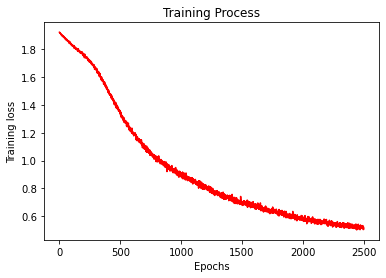

In [29]:
plt.figure()
plt.title('Training Process')
plt.plot(range(len(loss_trains)), loss_trains, color='r')
# plt.plot(range(len(loss_trains)), loss_trains, color='r')
plt.ylabel('Training loss')
plt.xlabel('Epochs')
plt.savefig('training_loss.pdf')
plt.show()

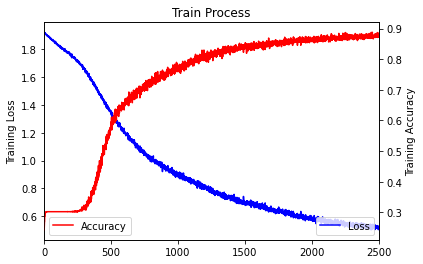

In [30]:
x = np.arange(0., len(loss_trains), 1)
y1 = loss_trains
y2 = acc_trains

fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(x, y1, 'b', label='Loss')
ax1.set_ylabel('Training Loss')
ax1.set_title("Train Process")

ax2 = ax1.twinx()  # this is the important function
ax2.plot(x, y2, 'r', label='Accuracy')
ax2.set_xlim([0, len(loss_trains)])
ax2.set_ylabel('Training Accuracy')
ax2.set_xlabel('Epochs')
ax1.legend(loc='lower right')
ax2.legend(loc='lower left')
plt.savefig('Training Process.png')
plt.show()

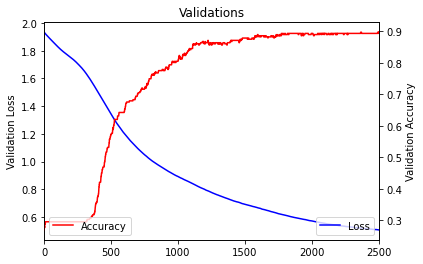

In [31]:
x = np.arange(0., len(loss_vals), 1)
y1 = loss_vals
y2 = acc_vals

fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(x, y1, 'b', label='Loss')
ax1.set_ylabel('Validation Loss')
ax1.set_title("Validations")

ax2 = ax1.twinx()  # this is the important function
ax2.plot(x, y2, 'r', label='Accuracy')
ax2.set_xlim([0, len(loss_trains)])
ax2.set_ylabel('Validation Accuracy')
ax2.set_xlabel('Epochs')
ax1.legend(loc='lower right')
ax2.legend(loc='lower left')
plt.savefig('Validations.png')
plt.show()